In [2]:
import tellurium as te
import pandas as pd
import matplotlib.pyplot as plt
import simulate
import numpy as np
import seaborn as sns
sns.set_style("ticks")

%matplotlib inline 

### Plot volume and HOG pathway:

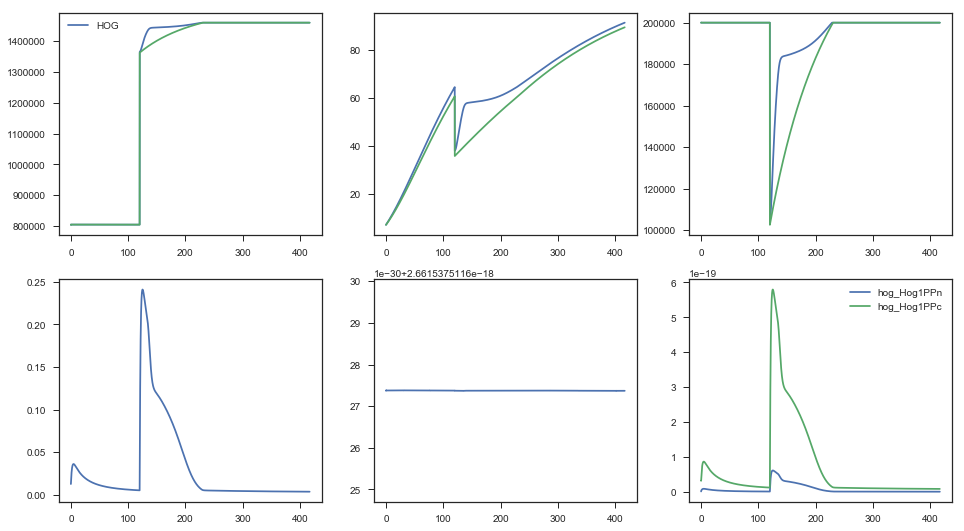

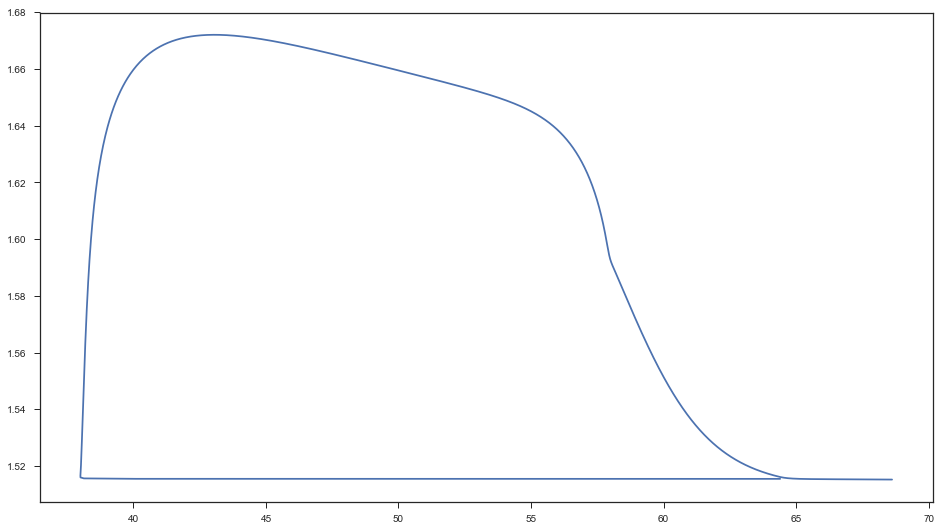

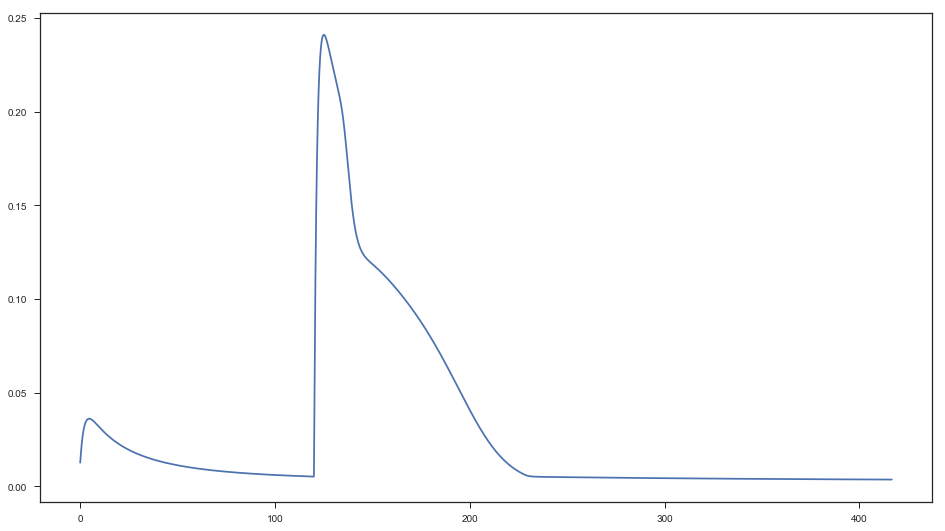

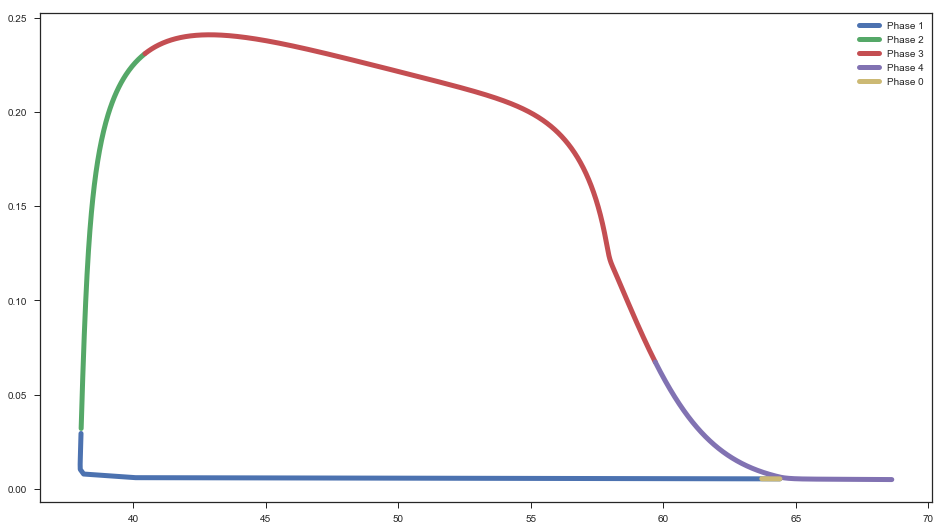

In [194]:
volume_and_hog_model = te.loadAntimonyModel("volume_and_hog.txt")
volume_model = te.loadAntimonyModel("volume_reference_radius.txt")

volume_and_hog_model.integrator.relative_tolerance = 1e-10
volume_model.integrator.relative_tolerance = 1e-10

volume_and_hog_model_species=['time','vol_V_tot_fl', '[vol_c_i]', 'hog_totalHog1PP','hog_n_totalHog1', 'hog_Hog1PPn', 'hog_Hog1PPc','hog_Hog1n', 'hog_Hog1c', '[hog_Hog1PPn]', '[hog_Hog1PPc]','[hog_Hog1n]', '[hog_Hog1c]', 'vol_pi_t', 'vol_pi_i']
volume_model_species=['time','V_tot_fl', '[c_i]', 'pi_t', 'pi_i']

end_time = 25000

k_adjust = 0.05
k_nutrient = k_adjust * 3.2*1e-15 # mM/s/um^2   
k_deg = k_adjust * 3.25*1e-15 # mM/s/um^2   

volume_and_hog_model.resetAll()
volume_model.resetAll()

volume_hog_param_dict = {'vol_k_nutrient': k_nutrient,
                         'vol_k_deg': k_deg
                         }

volume_param_dict = {'k_nutrient': k_nutrient,
                     'k_deg': k_deg
                    }


for param in volume_hog_param_dict.keys():
    volume_and_hog_model[param] = volume_hog_param_dict[param]
    
for param in volume_param_dict.keys():
    volume_model[param] = volume_param_dict[param]
    

#volume_model.resetAll()

shock = 260+240
hyposhock = 260+240

volume_model['shock_set_c_e'] = shock
volume_model['hyposhock_set_c_e'] = hyposhock

volume_and_hog_model['vol_shock_set_c_e'] = shock
volume_and_hog_model['vol_hyposhock_set_c_e'] = hyposhock

volume_model['r_b'] = 3 * volume_model['r_b_0']
volume_model['r_os'] = 3 * volume_model['r_os_0']
volume_model['[c_i]'] = volume_model['init([c_i])'] # set to inital value, otherwise concentration is recalulated to updated compartment size automatically

volume_and_hog_model['vol_r_b_0'] = 3 * volume_and_hog_model['vol_r_b_0']
volume_and_hog_model['vol_r_os_0'] = 3 * volume_and_hog_model['vol_r_os_0']
volume_and_hog_model.reset() # reset to inital values, otherwise concentrations are recalulated to updated compartment size automatically

volume_and_hog_sim=volume_and_hog_model.simulate(1, end_time, end_time, selections = volume_and_hog_model_species)
volume_sim=volume_model.simulate(1, end_time, end_time, selections = volume_model_species)

plt.figure(figsize=(16,9))

plt.subplot(2,3,1)
plt.plot(volume_and_hog_sim['time']/60,volume_and_hog_sim['vol_pi_i'],label = 'HOG')
plt.plot(volume_sim['time']/60,volume_sim['pi_i'])
#plt.xlim(90,200)
plt.legend()

plt.subplot(2,3,2)
plt.plot(volume_and_hog_sim['time']/60,volume_and_hog_sim['vol_V_tot_fl'],label = 'HOG')
plt.plot(volume_sim['time']/60,volume_sim['V_tot_fl'])
#plt.xlim(90,200)

plt.subplot(2,3,3)
plt.plot(volume_and_hog_sim['time']/60,volume_and_hog_sim['vol_pi_t'],label = 'HOG')
plt.plot(volume_sim['time']/60,volume_sim['pi_t'])
#plt.xlim(90,200)

plt.subplot(2,3,4)
plt.plot(volume_and_hog_sim['time']/60,volume_and_hog_sim['hog_totalHog1PP'])
#plt.xlim(90,200)
plt.subplot(2,3,5)
plt.plot(volume_and_hog_sim['time']/60,volume_and_hog_sim['hog_n_totalHog1'])

plt.subplot(2,3,6)
plt.plot(volume_and_hog_sim['time']/60,volume_and_hog_sim['hog_Hog1PPn'],label = 'hog_Hog1PPn')
plt.plot(volume_and_hog_sim['time']/60,volume_and_hog_sim['hog_Hog1PPc'],label = 'hog_Hog1PPc')
#plt.plot(volume_and_hog_sim['time']/60,volume_and_hog_sim['hog_n_totalHog1'],label = 'HOG')
#plt.plot(volume_and_hog_sim['time']/60,volume_and_hog_sim['hog_n_totalHog1'],label = 'HOG')



#plt.xlim(90,200)
plt.legend()

shock_event_time = int(volume_model['shock_event_time'])

total_Hog1 = (volume_and_hog_sim['hog_Hog1PPn'] + volume_and_hog_sim['hog_Hog1PPc'] + volume_and_hog_sim['hog_Hog1n'] + volume_and_hog_sim['hog_Hog1c'])
Rt = (volume_and_hog_sim['[hog_Hog1PPn]']+volume_and_hog_sim['[hog_Hog1n]']) * 1e-15 * volume_and_hog_sim['vol_V_tot_fl']/total_Hog1
enrichment = Rt
#enrichment = (Rt/(Rt[shock_event_time-1])) - 1  # minus baseline, which is the few Rt-points right before the shock according 



plt.figure(figsize=(16,9))
plt.plot(volume_and_hog_sim['vol_V_tot_fl'][shock_event_time-1:shock_event_time+8000],enrichment[shock_event_time-1:shock_event_time+8000])
plt.figure(figsize=(16,9))
plt.plot(volume_and_hog_sim['time']/60,volume_and_hog_sim['hog_totalHog1PP'])

plt.figure(figsize=(16,9))
phase_4 = [shock_event_time+4000,shock_event_time+8000]
phase_3 = [shock_event_time+200,shock_event_time+4000]
phase_2 = [shock_event_time+10,shock_event_time+200]
phase_1 = [shock_event_time-1,shock_event_time+10]
phase_0 = [shock_event_time-100,shock_event_time]
thickness = 5 # line thickness in phase plot
#plt.plot(volume_and_hog_sim['vol_V_tot_fl'][7100:250*60],volume_and_hog_sim['hog_totalHog1PP'][7100:250*60],label = 'hog_Hog1PPn',linewidth=thickness)
plt.plot(volume_and_hog_sim['vol_V_tot_fl'][phase_1[0]:phase_1[1]],volume_and_hog_sim['hog_totalHog1PP'][phase_1[0]:phase_1[1]],label = 'Phase 1',linewidth=thickness)
plt.plot(volume_and_hog_sim['vol_V_tot_fl'][phase_2[0]:phase_2[1]],volume_and_hog_sim['hog_totalHog1PP'][phase_2[0]:phase_2[1]],label = 'Phase 2',linewidth=thickness)
plt.plot(volume_and_hog_sim['vol_V_tot_fl'][phase_3[0]:phase_3[1]],volume_and_hog_sim['hog_totalHog1PP'][phase_3[0]:phase_3[1]],label = 'Phase 3',linewidth=thickness)
plt.plot(volume_and_hog_sim['vol_V_tot_fl'][phase_4[0]:phase_4[1]],volume_and_hog_sim['hog_totalHog1PP'][phase_4[0]:phase_4[1]],label = 'Phase 4',linewidth=thickness)
plt.plot(volume_and_hog_sim['vol_V_tot_fl'][phase_0[0]:phase_0[1]],volume_and_hog_sim['hog_totalHog1PP'][phase_0[0]:phase_0[1]],label = 'Phase 0',linewidth=thickness)


plt.legend()



plt.figure()


    